In [1]:
from mpl_rcParams import * 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import unitary_group

import scaling_lib.ftutils_np as ftutils
from scaling_lib.deltaN import *
from scaling_lib.simulation_tdwg_repo import WaveguideSimulationWithBackground
from scaling_lib.inverse_design import run_training_loop, TDwgNet
from scaling_lib.mode_solver import solve_modes
from scaling_lib.misc_helpers import smoothen_waveguide

In [6]:
Nmodes = 10

λ0 = 1.55 #um
ncore = 1.8
nclad = 1.7 
dn_wg = ncore-nclad

d_singlemode = λ0/2/np.sqrt(ncore**2-nclad**2)
k0 = 2*np.pi/λ0

d_wg = 1.5*Nmodes 
Lx = 3.5*d_wg
Nx = 2**8

In [7]:
dz = 0.4
Lz = 3e3*np.sqrt(Nmodes/3)
Nz = int(np.floor(Lz/dz))

z_axis = (np.arange(Nz)+1)*dz

In [8]:
dx = Lx/(Nx-1) # stepsize in transverse dimension
x_axis = ftutils.ft_t_axis(Nx, dx)

x2ind = lambda x: np.argmin(np.abs(x_axis-x))

In [9]:
dn_wg_slice = np.zeros(Nx)
dn_wg_slice[x2ind(-d_wg/2):x2ind(d_wg/2)] = dn_wg
dn_wg_slice = smoothen_waveguide(x_axis, dn_wg_slice, nclad * k0)

In [10]:
betas, Evecs = solve_modes(x_axis, nclad, k0, dn_wg_slice, Nmodes)
betas = betas - k0 * nclad

Text(0, 0.5, '$E_i(x)$')

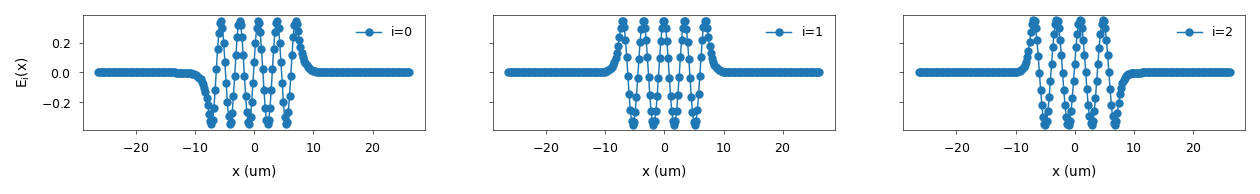

In [11]:
fig_height = 1
fig, axs = plt.subplots(1, 3, figsize=(10, fig_height), sharey=True)
for (i, ax) in enumerate(axs):
    plt.sca(ax)
    plt.plot(x_axis, np.real(Evecs[-i-1]), ".-", label=f"i={i}")
    plt.xlabel(r"$x$ (um)")
    plt.legend()
    
plt.sca(axs[0])
plt.ylabel(r"$E_i(x)$")

In [12]:
seed = 1
U_target = unitary_group.rvs(Nmodes, random_state=seed)
A = U2A(U_target, k0, Lz)

In [13]:
dn_prog = make_deltaN(A, Evecs, betas, x_axis, z_axis)

In [14]:
vmax = np.max(np.abs(U_target))

# Run rotating wave solver

In [15]:
from scaling_lib.misc_helpers import E2a, a2atilde, add_absorbing_boundary
from scaling_lib.simulation_tdwg_repo import WaveguideSimulationWithBackground

In [16]:
wg = WaveguideSimulationWithBackground(nclad, x_axis, z_axis, Ncom = 10)
wg.set_background_delta_n(torch.from_numpy(add_absorbing_boundary(x_axis, dn_wg_slice, k0)))

In [17]:
E_out = wg.run_simulation_slow(torch.from_numpy(Evecs), torch.from_numpy(dn_prog))
a_out = E2a(E_out.to(torch.cfloat), Evecs, x_axis)
U_num_rot = (a_out.T*np.exp(-1j*betas*wg.z_list[-1].numpy())).T #hmm, I wonder if this should be a function...

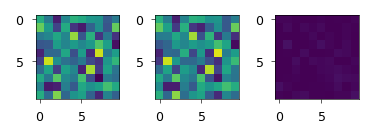

In [20]:
plt.subplot(1,3,1)
plt.imshow(np.abs(U_num_rot), vmin = 0, vmax = 0.65)
plt.subplot(1,3,2)
plt.imshow(np.abs(U_target), vmin = 0, vmax = 0.65)
plt.subplot(1,3,3)
plt.imshow(np.abs(U_target) - np.abs(U_num_rot), vmin = 0, vmax = 0.65)
plt.tight_layout()

# Inverse design

In [22]:
dn_wg_slice = torch.from_numpy(add_absorbing_boundary(x_axis, dn_wg_slice, k0))

In [26]:
dn_wg_torch = torch.tensor(dn_wg) 
U_target_torch = torch.tensor(U_target)

In [27]:
wg = WaveguideSimulationWithBackground(nclad, x_axis, z_axis)
wg.set_background_delta_n(dn_wg_slice)

In [28]:
delta_n_val = 2.5e-3
tdwg_pnn = TDwgNet(wg, delta_n_val, dn_wg_slice, Evecs, betas, dx, k0*nclad, 'cpu')

In [29]:
iterations = 100
lr = 0.5e-1
loss_list = run_training_loop(tdwg_pnn, U_target_torch, iterations, lr, batch_size = 10, device = 'cpu', print_interval=20)

2025-05-15--00-59-25--Iteration: 0, Loss: 1.00359
2025-05-15--01-01-44--Iteration: 20, Loss: 0.02456
2025-05-15--01-04-07--Iteration: 40, Loss: 0.00355
2025-05-15--01-06-26--Iteration: 60, Loss: 0.00078
2025-05-15--01-08-45--Iteration: 80, Loss: 0.00032
2025-05-15--01-09-43Converged at iteration: 88, Loss: 0.00027


In [57]:
with torch.no_grad():
    U_num_inv = tdwg_pnn(np.arange(Nmodes)).numpy()

In [58]:
avg_error_inv = np.mean(np.abs(U_num_inv-U_target))/np.mean(np.abs(U_target)) * 100
print(f"Average error for inverse design: {avg_error_inv:.2f}%")

Average error for inverse design: 1.64%


## Make plots

In [59]:
def plot_delta_n(z_axis, x_axis, delta_n, d_wg, y_lim_factor = 0.7):
    figsize_deltan = (3, 1.5*3/5)
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    img = plt.pcolormesh(z_axis/1000, x_axis, np.real(delta_n.T), cmap="coolwarm", vmax=1.25e-3, vmin=-1.25e-3)
    plt.axhline(d_wg/2,  color="gray", linestyle="-")
    plt.axhline(-d_wg/2, color="gray", linestyle="-")
    plt.ylim(-d_wg*y_lim_factor, d_wg*y_lim_factor)
    plt.xlabel("z (mm)")
    plt.ylabel("x (um)")
    plt.title(r"$\Delta n(x, z)$")

    visible_ticks = [tick for tick in ax.get_xticks() if ax.get_xlim()[0] <= tick <= ax.get_xlim()[1]]
    visible_ticks = [0] + visible_ticks  # Add 0 to the visible ticks
    ax.set_xticks(visible_ticks)

    # Create a separate figure for the colorbar
    fig_cbar = plt.figure(figsize=(0.1, figsize_deltan[1]))
    cbar = plt.colorbar(img, cax=plt.gca())
    cbar.set_label(r'$\Delta n$', rotation=270, labelpad=5)  # Reduced labelpad from 15 to 5
    
    # Display both figures
    plt.show()

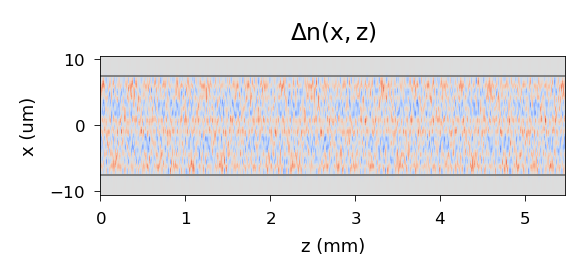

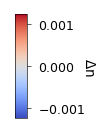

In [60]:
plot_delta_n(z_axis, x_axis, dn_prog, d_wg)

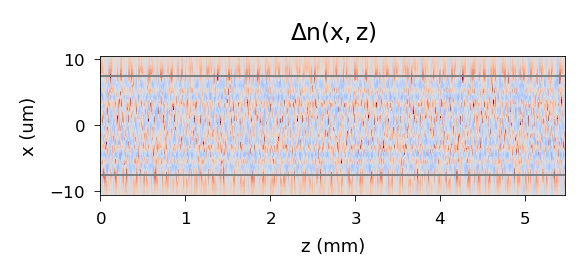

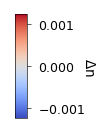

In [61]:
delta_n_inv = delta_n_val*(torch.clip(tdwg_pnn.mod.detach(), 0, 1.0)-0.5)
plot_delta_n(wg.z_axis, wg.x_axis, delta_n_inv, d_wg, y_lim_factor=0.7)

# Plot all of the unitary matrices

In [62]:
#the width of the figure should be 1.3

#make a function that can take in a U and do the "job"

In [63]:
vmax = np.max(np.abs(U_target))

In [64]:
def plot_unitary(U, vmax, title, colorbar_flag=True):
    figsize_U = (1.3, 1.3)
    
    # Plot main figure
    fig_main, ax = plt.subplots(figsize=figsize_U, dpi=200)
    img = plt.imshow(np.abs(U), cmap="bone_r", vmax=vmax)
    plt.title(title)
    plt.xticks([0, 2, 4, 6, 8])
    
    if colorbar_flag:
        # Create a separate figure for the colorbar
        fig_cbar = plt.figure(figsize=(0.1, figsize_U[1]))
        cbar = plt.colorbar(img, cax=plt.gca())
    
    # Display figures
    plt.show()

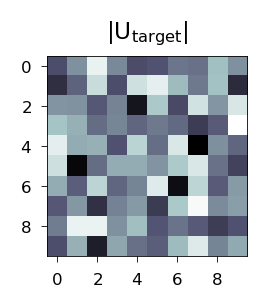

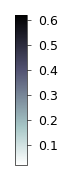

In [65]:
plot_unitary(U_target, vmax, r"$|U_{target}|$", colorbar_flag=True)

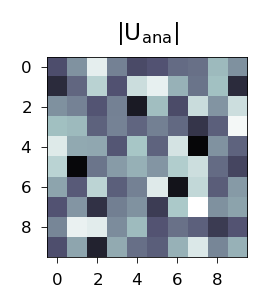

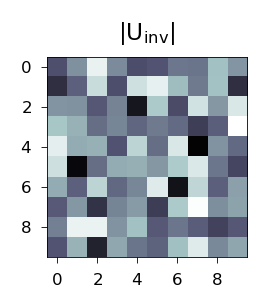

In [66]:
#use the plot_unitary function on U_num_rot and U_num_inv
plot_unitary(U_num_rot, vmax, r"$|U_{ana}|$", colorbar_flag=False)
plot_unitary(U_num_inv, vmax, r"$|U_{inv}|$", colorbar_flag=False)